# Proyecto - Feature Engineering
Andrea Cecilia Rivas Castañeda - 16001120

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.impute import KNNImputer, SimpleImputer

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import joblib

In [2]:
pd.pandas.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('kidney_disease.csv')
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


* Separamos el dataset en 2 partes: *entrenamiento* y *prueba*

In [4]:
#separamos data para entrenamiento y prueba,
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(['id', 'classification'], axis=1),
                        data['classification'],
                        test_size=0.15,
                        random_state=2021)

* Separación de variables categóricas y numéricas *(discretas y continuas)*.

In [5]:
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O' and (var not in ['rc', 'pcv', 'wc'])]
num_vars = [var for var in X_train.columns if var not in (cat_vars)]

discrete_vars = [var for var in num_vars if((len(data[var].unique()) < 20))]
cont_vars = [var for var in num_vars if var not in discrete_vars]

# Tratamiento de NA's

In [6]:
imputation_types = ['_mean', '_mode', '_median', '_num', '_knn', '_rand']

def graph_density(var, selected):
    sns.set_palette("Set2")
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(121)

    sns.kdeplot(X_train_copy[var], shade=True, label=var)
    for impType in imputation_types:
        sns.kdeplot(X_train_copy[var+impType], shade=True, label=var+impType)
        plt.legend()
    ax2 = fig.add_subplot(122)
    sns.kdeplot(X_train_copy[var], shade=True, label=var)
    sns.kdeplot(X_train_copy[selected], shade=True, label=selected)
    plt.legend()
    plt.show()

In [7]:
def imputation_Methods(var, num, range):
    # Imputación por Media
    X_train_copy[var+'_mean'] = X_train[var].fillna(X_train_copy[var].mean())
    # Imputación por Moda
    X_train_copy[var+'_mode'] = X_train[var].fillna(X_train[var].mode()[0])
    # Imputación por Mediana
    X_train_copy[var+'_median'] = X_train[var].fillna(X_train[var].median())
    # Imputación por un solo valor random
    X_train_copy[var+'_num'] = X_train[var].fillna(num)
    # Imputación por KNN
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    knn_Imp = imputer.fit_transform(np.array(X_train_copy[var]).reshape(-1, 1))
    X_train_copy[var+'_knn'] = knn_Imp
    # Imputación por random
    random.seed(8)
    X_train_copy[var+'_rand'] = X_train[var].fillna(random.uniform(range[0], range[1]))

## Tratamiento de valores especiales
#### pcv
* Tratamiento especial: los valores con chars los convertimos en Na y convertimos la columna en número

In [8]:
X_train['pcv'] = pd.to_numeric(X_train['pcv'].replace(to_replace='\t+', value=pd.NA, regex=True))
X_test['pcv'] = pd.to_numeric(X_test['pcv'].replace(to_replace='\t+', value=pd.NA, regex=True))

#### wc

In [9]:
for k,v in enumerate(X_train.wc):
    if(isinstance(v, str)):
        X_train.wc[k] = v.strip()
        if not(v.isnumeric()):
            X_train.wc[k] = None

for k,v in enumerate(X_test.wc):
    if(isinstance(v, str)):
        X_test.wc[k] = v.strip()
        if not(v.isnumeric()):
            X_test.wc[k] = None

In [10]:
X_train.wc = X_train.wc.astype(float)
X_test.wc = X_test.wc.astype(float)

#### rc

In [11]:
X_train['rc'] = pd.to_numeric(X_train['rc'].replace(to_replace='\t+', value=pd.NA, regex=True))
X_test['rc'] = pd.to_numeric(X_test['rc'].replace(to_replace='\t+', value=pd.NA, regex=True))

* Creamos una copia del dataset X_train para realizar el análisis de datos faltantes.

In [12]:
X_train_copy = X_train.copy()

## Variables Numéricas
### Variables Discretas

In [13]:
X_train[discrete_vars].isnull().mean().sort_values(ascending=False)

sg    0.108824
su    0.108824
al    0.100000
bp    0.029412
dtype: float64

In [14]:
X_test[discrete_vars].isnull().mean().sort_values(ascending=False)

al    0.200000
su    0.200000
sg    0.166667
bp    0.033333
dtype: float64

#### sg

In [15]:
X_train['sg'].describe()

count    303.000000
mean       1.017442
std        0.005767
min        1.005000
25%        1.010000
50%        1.020000
75%        1.020000
max        1.025000
Name: sg, dtype: float64

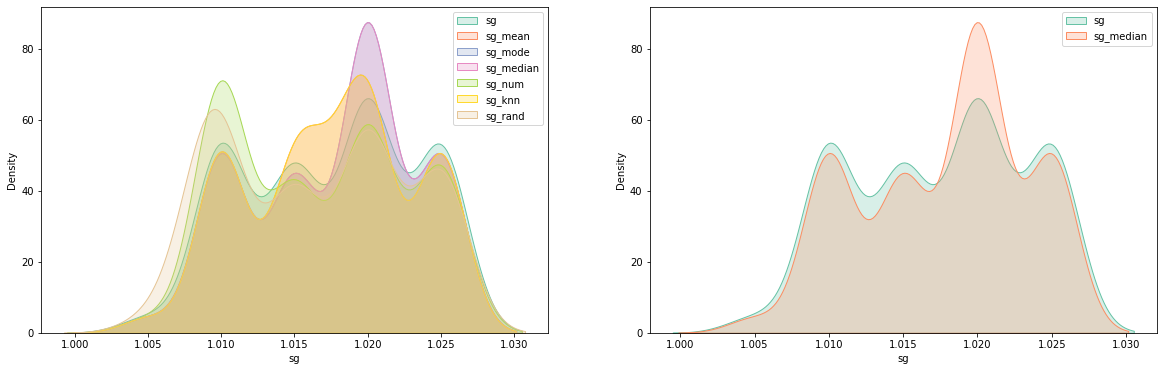

In [16]:
imputation_Methods('sg', 1.01, [1.002, 1.03])
graph_density('sg', 'sg_median')

In [17]:
X_train['sg'] = X_train['sg'].fillna(X_train['sg'].median())
X_test['sg'] = X_test['sg'].fillna(X_train['sg'].median())

#### al

In [18]:
X_train['al'].describe()

count    306.000000
mean       1.000000
std        1.357432
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        5.000000
Name: al, dtype: float64

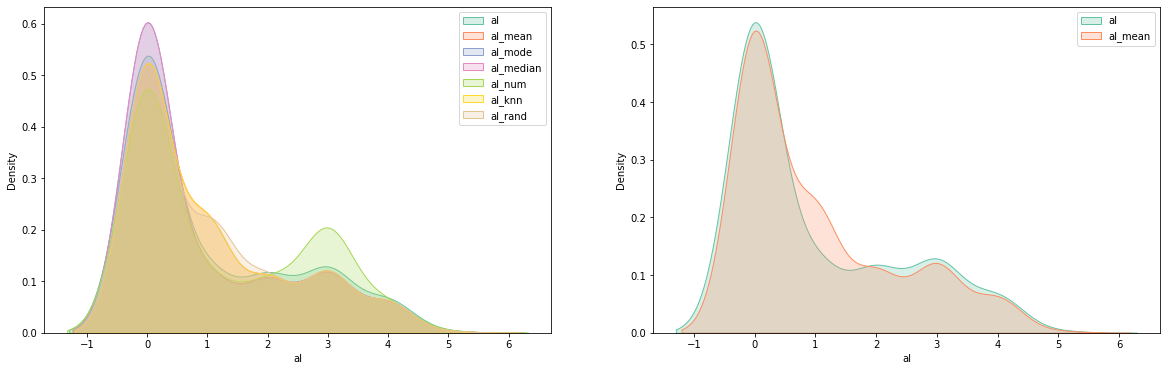

In [19]:
imputation_Methods('al', 3, [0,5])
graph_density('al', 'al_mean')

* Se seleccinó imputación por media.

In [20]:
X_train['al'] = X_train['al'].fillna(X_train['al'].mean())
X_test['al'] = X_test['al'].fillna(X_train['al'].mean())

#### su

In [21]:
X_train_copy['su'].describe()

count    303.000000
mean       0.475248
std        1.129913
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.000000
Name: su, dtype: float64

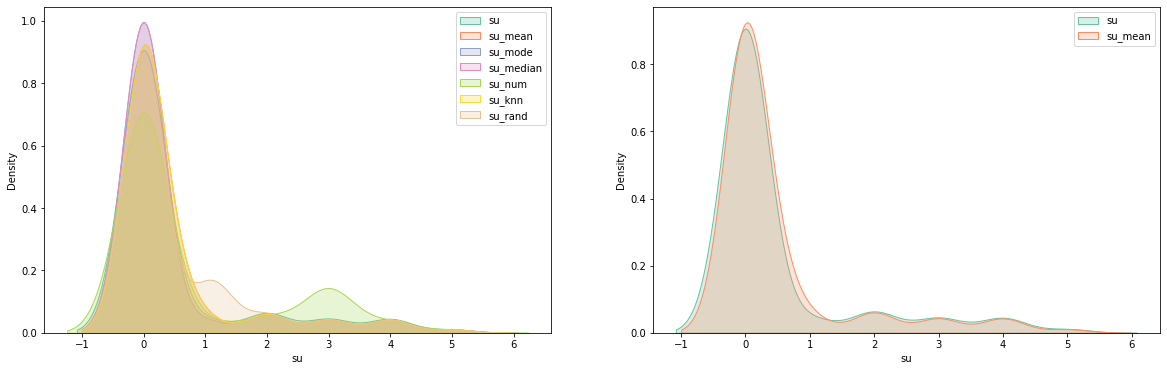

In [22]:
imputation_Methods('su', 3, [0,5])
graph_density('su', 'su_mean')

In [23]:
X_train['su'] = X_train['su'].fillna(X_train['su'].mean())
X_test['su'] = X_test['su'].fillna(X_train['su'].mean())

#### bp

In [24]:
X_train_copy['bp'].describe()

count    330.000000
mean      76.151515
std       14.013934
min       50.000000
25%       70.000000
50%       75.000000
75%       80.000000
max      180.000000
Name: bp, dtype: float64

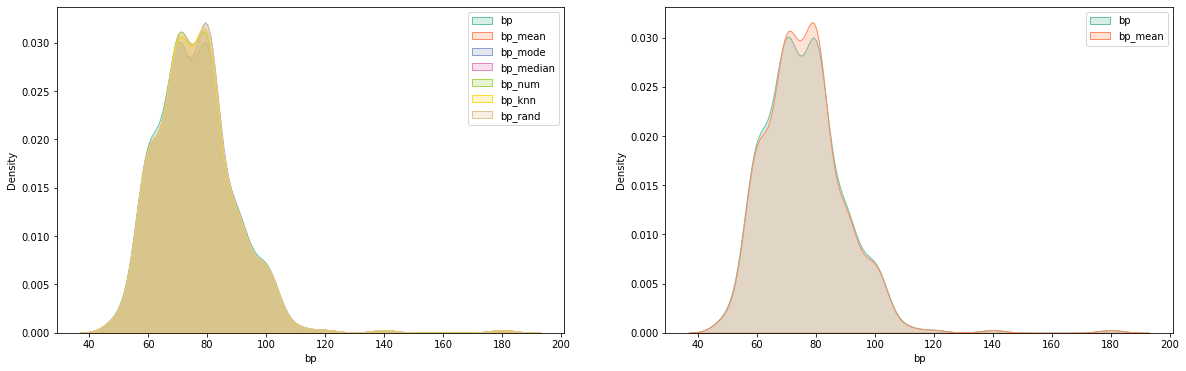

In [25]:
imputation_Methods('bp', 75, [50,180])
graph_density('bp', 'bp_mean')

In [26]:
X_train['bp'] = X_train['bp'].fillna(X_train['bp'].mean())
X_test['bp'] = X_test['bp'].fillna(X_train['bp'].mean())

### Variables Continuas

In [27]:
cont_vars = [var for var in num_vars if var not in discrete_vars]
cont_vars

['age', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

#### age

In [28]:
X_train_copy['age'].describe()

count    331.000000
mean      50.646526
std       17.415218
min        2.000000
25%       41.000000
50%       54.000000
75%       63.000000
max       83.000000
Name: age, dtype: float64

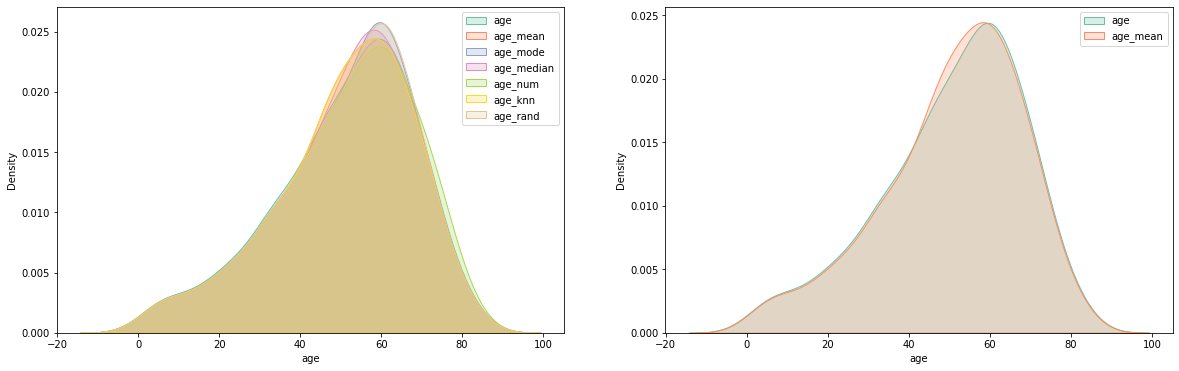

In [29]:
imputation_Methods('age', 75, [50,100])
graph_density('age', 'age_mean')

In [30]:
X_train['age'] = X_train['age'].fillna(X_train['age'].mean())
X_test['age'] = X_test['age'].fillna(X_train['age'].mean())

#### bgr

In [31]:
X_train_copy['bgr'].describe()

count    298.000000
mean     150.000000
std       82.408362
min       22.000000
25%      100.000000
50%      122.000000
75%      165.000000
max      490.000000
Name: bgr, dtype: float64

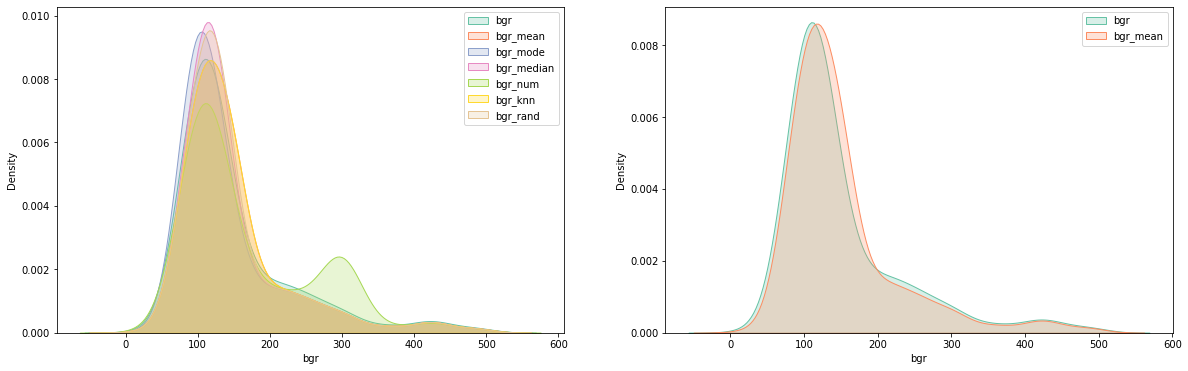

In [32]:
imputation_Methods('bgr', 300, [22,500])
graph_density('bgr', 'bgr_mean')

In [33]:
X_train['bgr'] = X_train['bgr'].fillna(X_train['bgr'].mean())
X_test['bgr'] = X_test['bgr'].fillna(X_train['bgr'].mean())

#### bu

In [34]:
X_train_copy['bu'].describe()

count    325.000000
mean      56.336000
std       51.735323
min        1.500000
25%       26.000000
50%       40.000000
75%       60.000000
max      391.000000
Name: bu, dtype: float64

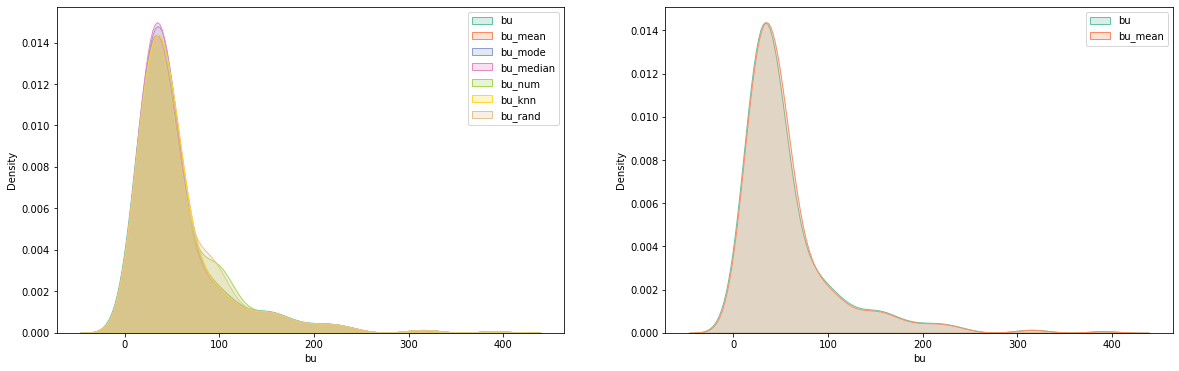

In [35]:
imputation_Methods('bu', 100, [2,400])
graph_density('bu', 'bu_mean')

In [36]:
X_train['bu'] = X_train['bu'].fillna(X_train['bu'].mean())
X_test['bu'] = X_test['bu'].fillna(X_train['bu'].mean())

#### sc

In [37]:
X_train_copy['sc'].describe()

count    326.000000
mean       3.122699
std        6.096383
min        0.400000
25%        0.900000
50%        1.200000
75%        2.800000
max       76.000000
Name: sc, dtype: float64

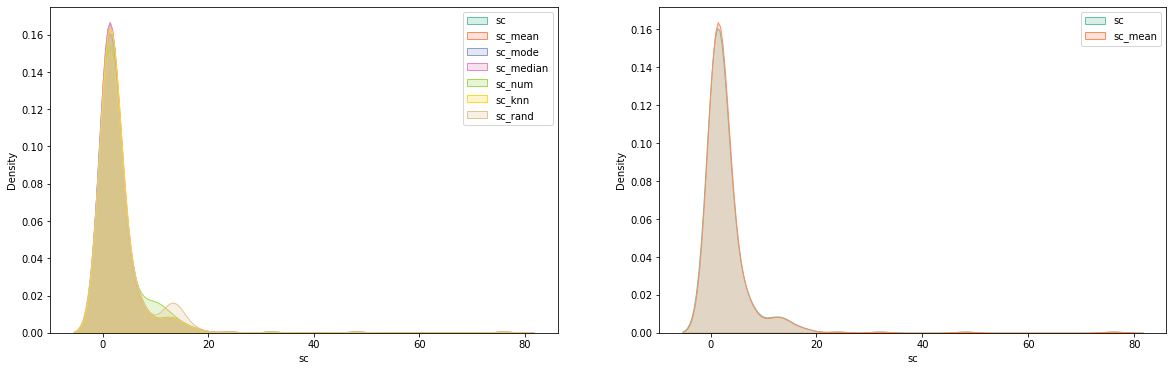

In [38]:
imputation_Methods('sc', 10, [0,60])
graph_density('sc', 'sc_mean')

In [39]:
X_train['sc'] = X_train['sc'].fillna(X_train['sc'].mean())
X_test['sc'] = X_test['sc'].fillna(X_train['sc'].mean())

#### sod

In [40]:
X_train_copy['sod'].describe()

count    273.000000
mean     137.368132
std       10.894591
min        4.500000
25%      135.000000
50%      138.000000
75%      142.000000
max      163.000000
Name: sod, dtype: float64

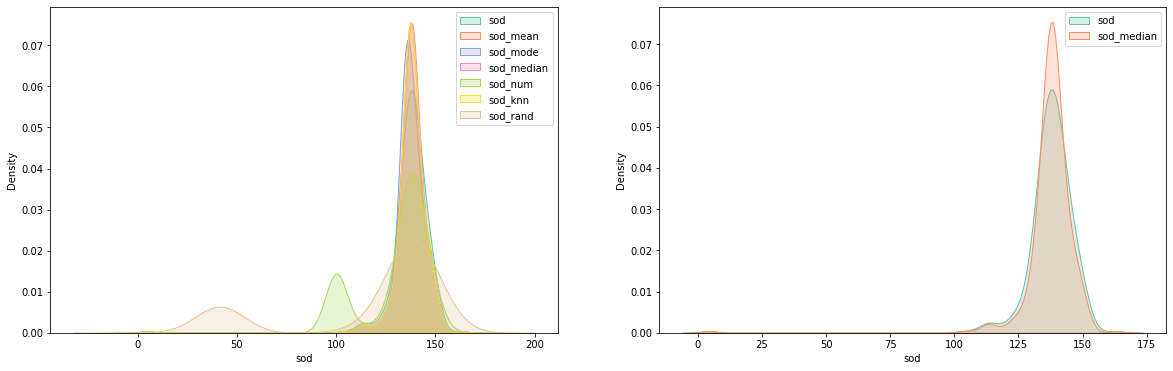

In [41]:
imputation_Methods('sod', 100, [5,165])
graph_density('sod', 'sod_median')

In [42]:
X_train['sod'] = X_train['sod'].fillna(X_train['sod'].median())
X_test['sod'] = X_test['sod'].fillna(X_train['sod'].median())

#### pot

In [43]:
X_train_copy['pot'].describe()

count    272.000000
mean       4.661765
std        3.407352
min        2.500000
25%        3.800000
50%        4.400000
75%        4.900000
max       47.000000
Name: pot, dtype: float64

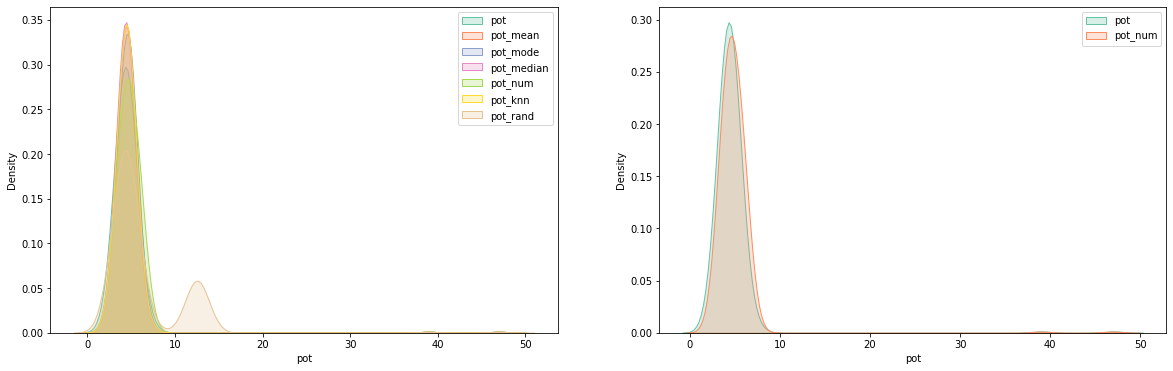

In [44]:
imputation_Methods('pot', 6, [3,45])
graph_density('pot', 'pot_num')

In [45]:
X_train['pot'] = X_train['pot'].fillna(6)
X_test['pot'] = X_test['pot'].fillna(6)

#### hemo

In [46]:
X_train['hemo'].describe()

count    298.000000
mean      12.611409
std        2.938117
min        3.100000
25%       10.625000
50%       13.000000
75%       15.000000
max       17.800000
Name: hemo, dtype: float64

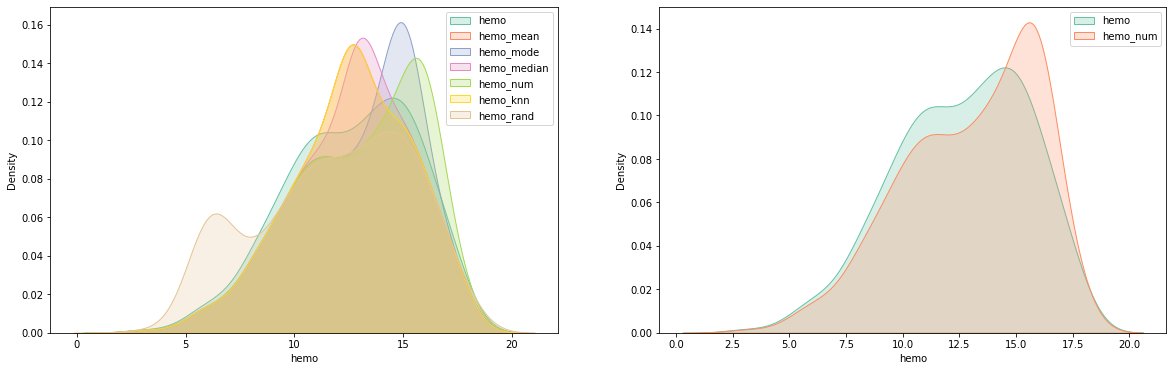

In [47]:
imputation_Methods('hemo', 16, [3,17])
graph_density('hemo', 'hemo_num')

In [48]:
X_train['hemo'] = X_train['hemo'].fillna(16)
X_test['hemo'] = X_test['hemo'].fillna(16)

#### pcv

In [49]:
X_train['pcv'].describe()

count    283.000000
mean      39.038869
std        9.073493
min        9.000000
25%       32.500000
50%       41.000000
75%       45.000000
max       54.000000
Name: pcv, dtype: float64

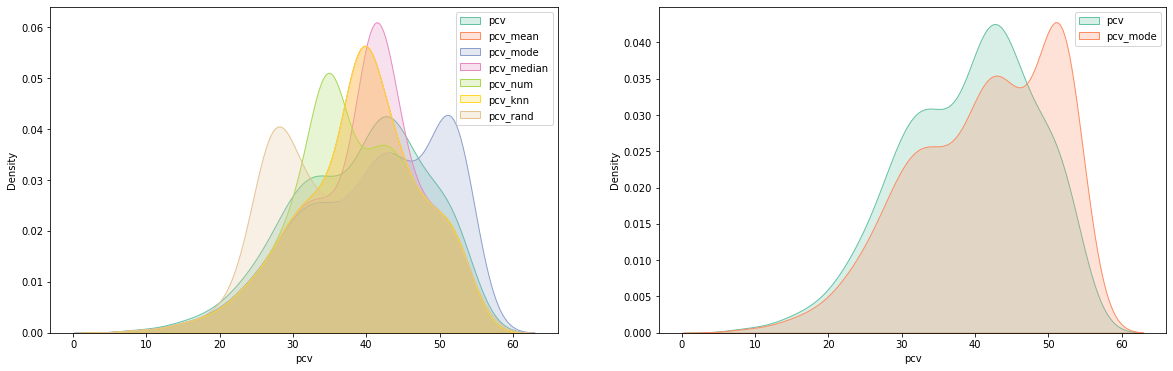

In [50]:
imputation_Methods('pcv', 35, [20,52])
graph_density('pcv', 'pcv_mode')

In [51]:
X_train['pcv'] = X_train['pcv'].fillna(X_train['pcv'].mode()[0])
X_test['pcv'] = X_test['pcv'].fillna(X_train['pcv'].mode()[0])

#### wc

In [52]:
X_train['wc'].describe()

count      322.000000
mean      8154.037267
std       2850.206175
min       4200.000000
25%       6300.000000
50%       7500.000000
75%       9475.000000
max      21600.000000
Name: wc, dtype: float64

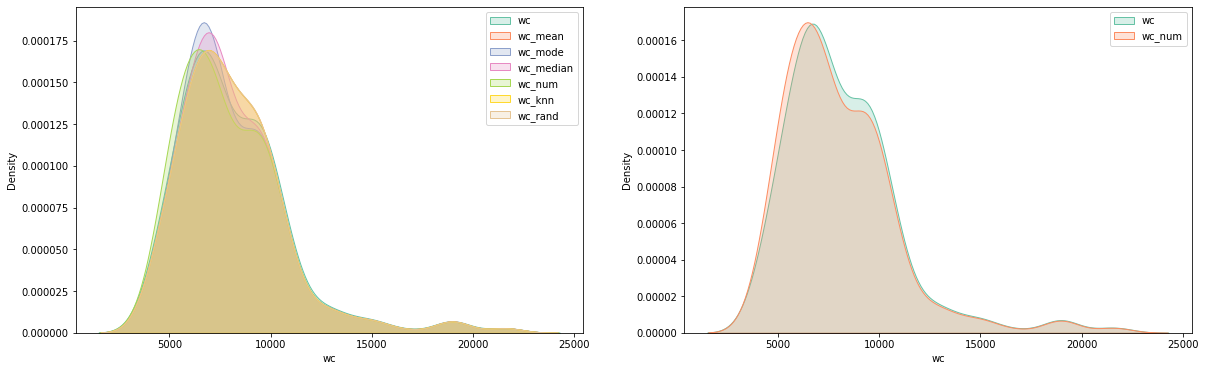

In [53]:
imputation_Methods('wc', 5352, [4250,21550])
graph_density('wc', 'wc_num')

In [54]:
X_train['wc'] = X_train['wc'].fillna(5352)
X_test['wc'] = X_test['wc'].fillna(5352)

#### rc

In [55]:
X_train['rc'].describe()

count    230.000000
mean       4.728696
std        1.037192
min        2.100000
25%        4.000000
50%        4.800000
75%        5.500000
max        8.000000
Name: rc, dtype: float64

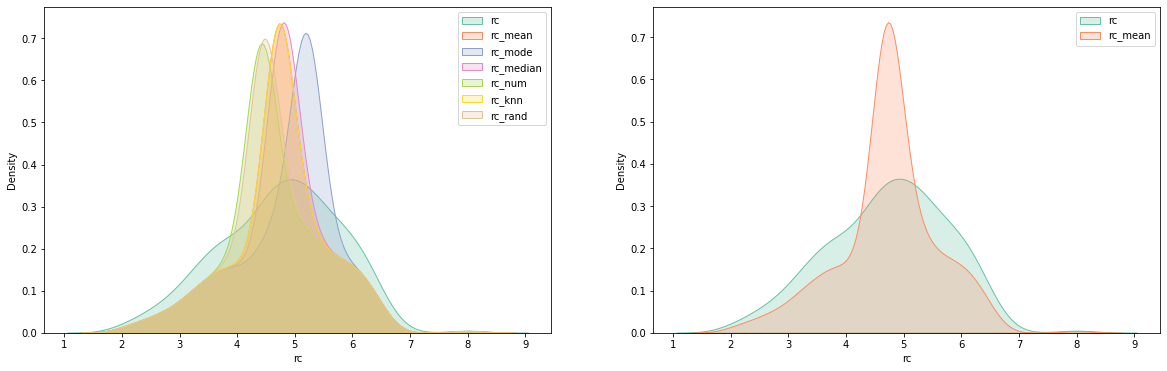

In [56]:
imputation_Methods('rc', 4.4, [4,6])
graph_density('rc', 'rc_mean')

In [57]:
X_train['rc'] = X_train['rc'].fillna(X_train['rc'].mean())
X_test['rc'] = X_test['rc'].fillna(X_train['rc'].mean())

## Variables Categóricas

In [58]:
X_train[cat_vars].isnull().mean()

rbc      0.350000
pc       0.152941
pcc      0.011765
ba       0.011765
htn      0.005882
dm       0.005882
cad      0.005882
appet    0.002941
pe       0.002941
ane      0.002941
dtype: float64

#### rbc

In [59]:
X_train['rbc'].value_counts()/X_train.shape[0]

normal      0.532353
abnormal    0.117647
Name: rbc, dtype: float64

In [60]:
X_train['rbc'] = X_train['rbc'].fillna('undefined')
X_test['rbc'] = X_test['rbc'].fillna('undefined')

#### pc

In [61]:
X_train['pc'].value_counts()/X_train.shape[0]

normal      0.650000
abnormal    0.197059
Name: pc, dtype: float64

In [62]:
X_train['pc'] = X_train['pc'].fillna('undefined')
X_test['pc'] = X_test['pc'].fillna('undefined')

#### pcc

In [63]:
X_train['pcc'].value_counts()/X_train.shape[0]

notpresent    0.876471
present       0.111765
Name: pcc, dtype: float64

In [64]:
X_train['pcc'] = X_train['pcc'].fillna('undefined')
X_test['pcc'] = X_test['pcc'].fillna('undefined')

#### ba

In [65]:
X_train['ba'].value_counts()/X_train.shape[0]

notpresent    0.932353
present       0.055882
Name: ba, dtype: float64

In [66]:
X_train['ba'] = X_train['ba'].fillna('undefined')
X_test['ba'] = X_test['ba'].fillna('undefined')

#### htn

In [67]:
X_train['htn'].value_counts()/X_train.shape[0]

no     0.644118
yes    0.350000
Name: htn, dtype: float64

In [68]:
X_train['htn'] = X_train['htn'].fillna('undefined')
X_test['htn'] = X_test['htn'].fillna('undefined')

#### dm

In [69]:
X_train['dm'].value_counts()/X_train.shape[0]

no       0.664706
yes      0.317647
\tno     0.005882
\tyes    0.002941
 yes     0.002941
Name: dm, dtype: float64

In [70]:
X_train['dm'] = X_train['dm'].fillna('undefined')
X_test['dm'] = X_test['dm'].fillna('undefined')

#### cad

In [72]:
X_train['cad'].value_counts()/X_train.shape[0]

no      0.905882
yes     0.085294
\tno    0.002941
Name: cad, dtype: float64

In [73]:
X_train['cad'] = X_train['cad'].fillna('undefined')
X_test['cad'] = X_test['cad'].fillna('undefined')

#### appet

In [74]:
X_train['appet'].value_counts()/X_train.shape[0]

good    0.791176
poor    0.205882
Name: appet, dtype: float64

In [75]:
X_train['appet'] = X_train['appet'].fillna('medium')
X_test['appet'] = X_test['appet'].fillna('medium')

#### pe

In [76]:
X_train['pe'].value_counts()/X_train.shape[0]

no     0.814706
yes    0.182353
Name: pe, dtype: float64

In [77]:
X_train['pe'] = X_train['pe'].fillna('undefined')
X_test['pe'] = X_test['pe'].fillna('undefined')

#### ane

In [79]:
X_train['ane'].value_counts()/X_train.shape[0]

no     0.858824
yes    0.138235
Name: ane, dtype: float64

In [80]:
X_train['ane'] = X_train['ane'].fillna('undefined')
X_test['ane'] = X_test['ane'].fillna('undefined')